In [1]:
import os 
import sys  

project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)

from MultiScaleUtils import create_downscale_graph,create_downscale_graph,create_transition_graph

In [2]:
import numpy as np
import dgl
import matplotlib.pyplot as plt
import networkx as nx


### Test create_downscale_graph graphique 

IndexError: index 9 is out of bounds for axis 0 with size 5

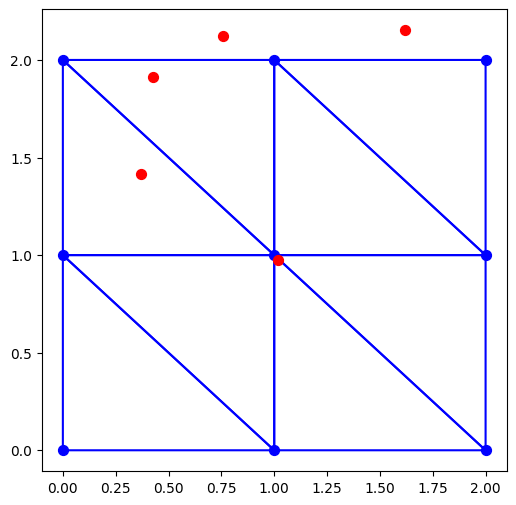

In [4]:
def plot_graph(X_fin, X_coarse, Triangles, graph):
    """
    Affiche le maillage grossier, les points fins et les arêtes créées à partir du graphe DGL.
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Tracer le maillage grossier
    for tri in Triangles:
        pts = X_coarse[tri]
        polygon = plt.Polygon(pts, edgecolor="blue", fill=None, linewidth=1.5)
        ax.add_patch(polygon)

    # Tracer les points grossiers
    ax.scatter(X_coarse[:, 0], X_coarse[:, 1], color="blue", label="Points grossiers", s=50, zorder=2)

    # Tracer les points fins
    ax.scatter(X_fin[:, 0], X_fin[:, 1], color="red", label="Points fins", s=50, zorder=3)

    # Extraire les arêtes du graphe
    src_nodes = graph.edges()[0].numpy()
    dst_nodes = graph.edges()[1].numpy()-  X_fin.shape[0]

    # Tracer les arêtes
    for src, dst in zip(src_nodes, dst_nodes):
        x1, y1 = X_fin[src]  # Point fin
        x2, y2 = X_coarse[dst]  # Point grossier connecté
        ax.plot([x1, x2], [y1, y2], color="black", linestyle="dashed", linewidth=1, alpha=0.7)

    ax.legend()
    ax.set_title("Graphe DGL : Connexions entre points fins et maillage")
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect("equal")
    plt.show()

# Génération d'un maillage plus grand
X_coarse = np.array([[0, 0], [1, 0], [2, 0], 
                     [0, 1], [1, 1], [2, 1], 
                     [0, 2], [1, 2], [2, 2]])

Triangles = np.array([[0, 1, 3], [1, 4, 3], [1, 2, 4], [2, 5, 4], 
                      [3, 4, 6], [4, 7, 6], [4, 5, 7], [5, 8, 7]])

# Génération aléatoire de points fins dans la grille
num_points = 45
X_fin = np.random.uniform(0, 2.3, size=(num_points, 2))

# Génération du graphe
graph = create_transition_graph(X_fin, X_coarse, Triangles)

# Affichage graphique du graphe
plot_graph(X_fin, X_coarse, Triangles, graph)

### Test Downscale Graph real datas

In [4]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info

mesh_list = ['/work/m24046/m24046mrcr/results_data_30min/maillage_3.slf']
res_mesh_fine = TelemacFile(mesh_list[0])
X_fin,triangles_fin = add_mesh_info(res_mesh_fine)

mesh_list = ['/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex16/Mesh16_corrige.slf']
res_mesh = TelemacFile(mesh_list[0])
X_coarse,triangles_coarse = add_mesh_info(res_mesh)

In [5]:
graph = create_downscale_graph(X_fin, X_coarse, triangles_coarse)

In [6]:
print(graph)

Graph(num_nodes=419010, num_edges=1226265,
      ndata_schemes={}
      edata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32)})


### Test update 

__________________
node feat
tensor([[4., 9., 3., 0., 3.],
        [9., 7., 3., 7., 3.],
        [1., 6., 6., 9., 8.],
        [6., 6., 8., 4., 3.],
        [6., 9., 1., 4., 4.],
        [1., 9., 9., 9., 0.],
        [1., 2., 3., 0., 5.],
        [5., 2., 9., 1., 8.],
        [8., 3., 6., 9., 1.],
        [7., 3., 5., 2., 1.],
        [0., 9., 3., 1., 1.],
        [0., 3., 6., 6., 7.],
        [9., 6., 3., 4., 5.],
        [0., 8., 2., 8., 2.],
        [7., 5., 0., 0., 8.],
        [1., 9., 6., 1., 0.],
        [2., 9., 4., 3., 9.],
        [3., 9., 3., 9., 8.],
        [5., 3., 2., 8., 5.]])
msg
__________________
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 0., 

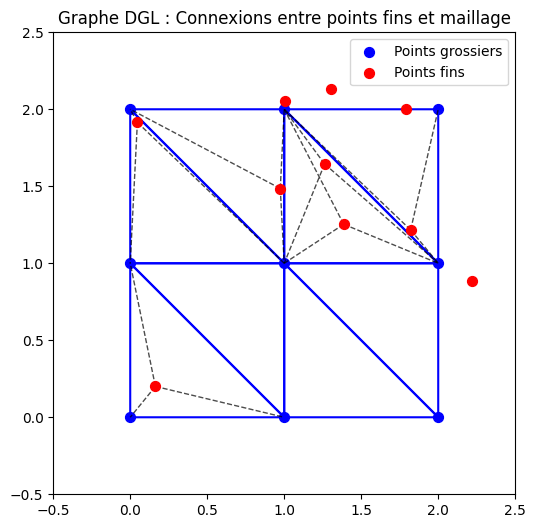

le point 0,0 a 1.0 connection avec des points fins
le point 1,0 a 1.0 connection avec des points fins
le point 2,0 a 0.0 connection avec des points fins
le point 0,1 a 2.0 connection avec des points fins
le point 1,1 a 4.0 connection avec des points fins
le point 2,1 a 3.0 connection avec des points fins
le point 0,2 a 2.0 connection avec des points fins
le point 1,2 a 4.0 connection avec des points fins
le point 2,2 a 1.0 connection avec des points fins


In [7]:
import torch
import torch.nn as nn
import numpy as np
import dgl
from CustomMeshGraphNet import MeshGraphNetProcessor,MeshGraphMLP,get_activation

class ZeroNodeMLP(nn.Module):
    def __init__(self, node_dim):
        super(ZeroNodeMLP, self).__init__()
        self.node_dim = node_dim

    def forward(self, x):
        # x is of shape [batch_size,message_dim+ node_dim]
        node_feat = x[:, -self.node_dim:]
        msg = x[:, :-self.node_dim]
        print("__________________")
        print("node feat")
        print(node_feat)
        print("msg")
        print("__________________")
        print(msg)
        print("__________________")
        # For each row, check if the message is all zeros.
        is_msg_zero = torch.all(msg == 0, dim=1, keepdim=True)  # shape [batch_size, 1]
        print(is_msg_zero.shape)
        # Create a tensor of zeros of shape [batch_size, node_dim]
        zeros = torch.zeros(x.size(0), self.node_dim, device=x.device)
        # If message is zero, output zero; else output the message.
        # Using torch.where applies the condition row-wise.
        out = torch.where(is_msg_zero, zeros, msg)
        return out

class IdentityEdgeMLP(nn.Module):
    def __init__(self, node_dim):
        super(IdentityEdgeMLP, self).__init__()
        self.node_dim = node_dim

    def forward(self, efeat, nfeat, graph):
        # x is of shape [batch_size, node_dim + message_dim]
        #print(efeat)
        return torch.zeros(efeat.shape)
    
def test_fine_nodes_unchanged():
    # For reproducibility:
    np.random.seed(0)
    torch.manual_seed(0)

    # --- Define the coarse grid and triangles (same as your example) ---
    X_coarse = np.array([
        [0, 0], [1, 0], [2, 0],
        [0, 1], [1, 1], [2, 1],
        [0, 2], [1, 2], [2, 2]
    ])
    Triangles = np.array([
        [0, 1, 3], [1, 4, 3], [1, 2, 4], [2, 5, 4],
        [3, 4, 6], [4, 7, 6], [4, 5, 7], [5, 8, 7]
    ])

    # --- Generate a set of fine points (e.g. 15 points) ---
    num_points = 10
    X_fin = np.random.uniform(0, 2.3, size=(num_points, 2))
    
    
    # --- Create the directed downscale graph ---
    # Fine nodes: indices 0 .. num_points-1
    # Coarse nodes: indices num_points .. num_points+len(X_coarse)-1
    graph = create_downscale_graph(X_fin, X_coarse, Triangles)
    
    total_nodes = graph.num_nodes()

    # --- Initialize node features with known values ---
    # For example, we assign random features.
    node_features = torch.randint(0,10,(total_nodes, 5))
    # Set edge features to zeros so that no nonzero message is passed.
    edge_features = torch.ones(graph.num_edges(), 5)

    
    # --- Instantiate the MeshGraphNetProcessor ---
    processor = MeshGraphNetProcessor(
        processor_size=1,      # One pair of (edge, node) blocks
        input_dim_node=5,
        input_dim_edge=5,
        num_layers_node=2,
        num_layers_edge=2,
        aggregation="sum",
        norm_type="LayerNorm",
        activation_fn=nn.ReLU(),
        do_concat_trick=False,
    )

    # --- Replace each node block's MLP with our ZeroNodeMLP ---
    # This makes the node block effectively return 0, so the update is:
    # updated_node = node_features + 0 = node_features.
    for module in processor.processor_layers:
        if hasattr(module, 'node_mlp'):
            module.node_mlp = ZeroNodeMLP(node_dim=5)
        if hasattr(module, 'edge_mlp'):
            module.edge_mlp = IdentityEdgeMLP(node_dim=5)

    # --- Forward pass ---
    updated_node_features = processor(node_features, edge_features, graph)

    # --- Check the fine nodes ---
    # Fine nodes are indices 0..num_points-1.
    fine_original = node_features[:num_points]
    fine_updated = updated_node_features[:num_points]

    # Compute the maximum difference
    max_diff = (fine_updated - fine_original).abs().max().item()
    print("Max difference for fine nodes (should be 0):", max_diff)
    print("\nOriginal fine node features (first fine node):", fine_original[0])
    print("Updated fine node features (first fine node):", fine_updated[0])

    # Optionally, display coarse node features (they might be updated differently)
    coarse_updated = updated_node_features[num_points:]
    print("\nOld coarse node features:",node_features[num_points:])
    print("\nUpdated coarse node features:",coarse_updated)
    
    
    plot_graph(X_fin, X_coarse, Triangles, graph)

    connection = ((coarse_updated - node_features[num_points:])[:,0])
    for i in range(9):
        print("le point {},{} a {} connection avec des points fins".format(X_coarse[i,0],X_coarse[i,1],connection[i]))
    
if __name__ == "__main__":
    test_fine_nodes_unchanged()



### Conclusion des tests :

En modifiant le processor pour n'update que les noeuds ayant un msg non nul, on a pu tester que les connexions entre les noeuds crée par le graphe était les bonnes et les mise à jours aussi. Ce code va être utilisé pour créer les graphes d'upscale et de downscale qui ont la même structure dans le MsMGN meshgraphnet. La validation visuelle a aussi validée le code. 

### Pseudocode

- obtention du graphe fin classique et du graphe base grossier
- creation des deux graphe de down et up 
- encodage des valeurs (edge sur down et up) et tt sur grossier et fin (2+2+2 encodeur) 
- pour un vcycle -> processor_fin_1 -> down (verifier l'alignement) -> processor_grossier_1 -> up (verifier l'alignement) -> rocessor_fin_2

output 

verifier l'alignement des indices des nodes values , verifier qu'on a pas de coupûre du graphe de calcul 


Les indices sont features_grossier-features_fin 

In [8]:
### Creation des encodeurs pour le graphe fin 
from MultiScaleUtils import create_downscale_graph,create_downscale_graph

input_dim_edges = 3

hidden_dim_processor = 30
hidden_dim_edge_encoder = 30
hidden_dim_node_encoder = 30

activation_fn  = get_activation('selu')

num_layers_edge_encoder = 2
num_layers_node_encoder = 2

input_dim_nodes = 9
input_dim_nodes_coarse = 6

processor_size = 3
num_layers_node_processor = 2
num_layers_edge_processor = 2

aggregation = 'sum'
do_concat_trick = True 
num_processor_checkpoint_segments = 0

### creation des encodeurs fins

edge_encoder_fine = MeshGraphMLP(
            input_dim_edges,
            output_dim=hidden_dim_processor,
            hidden_dim=hidden_dim_edge_encoder,
            hidden_layers=num_layers_edge_encoder,
            activation_fn=activation_fn,
            norm_type="LayerNorm",
            recompute_activation=False,
        )

node_encoder_fine = MeshGraphMLP(
            input_dim_nodes,
            output_dim=hidden_dim_processor,
            hidden_dim=hidden_dim_node_encoder,
            hidden_layers=num_layers_node_encoder,
            activation_fn=activation_fn,
            norm_type="LayerNorm",
            recompute_activation=False,
        )
        
### Creation des encodeurs pour le graphe grossier 

node_encoder_coarse = MeshGraphMLP(
            input_dim_nodes_coarse,
            output_dim=hidden_dim_processor,
            hidden_dim=hidden_dim_node_encoder,
            hidden_layers=num_layers_node_encoder,
            activation_fn=activation_fn,
            norm_type="LayerNorm",
            recompute_activation=False,
        )

####

processor_fin_1 = MeshGraphNetProcessor(
            processor_size=processor_size,
            input_dim_node=hidden_dim_processor,
            input_dim_edge=hidden_dim_processor,
            num_layers_node=num_layers_node_processor,
            num_layers_edge=num_layers_edge_processor,
            aggregation=aggregation,
            norm_type="LayerNorm",
            activation_fn=activation_fn,
            do_concat_trick=do_concat_trick,
            num_processor_checkpoint_segments=num_processor_checkpoint_segments,
        )

processor_up = MeshGraphNetProcessor(
            processor_size=processor_size,
            input_dim_node=hidden_dim_processor,
            input_dim_edge=hidden_dim_processor,
            num_layers_node=num_layers_node_processor,
            num_layers_edge=num_layers_edge_processor,
            aggregation=aggregation,
            norm_type="LayerNorm",
            activation_fn=activation_fn,
            do_concat_trick=do_concat_trick,
            num_processor_checkpoint_segments=num_processor_checkpoint_segments,
        )

processor_coarse = MeshGraphNetProcessor(
            processor_size=processor_size,
            input_dim_node=hidden_dim_processor,
            input_dim_edge=hidden_dim_processor,
            num_layers_node=num_layers_node_processor,
            num_layers_edge=num_layers_edge_processor,
            aggregation=aggregation,
            norm_type="LayerNorm",
            activation_fn=activation_fn,
            do_concat_trick=do_concat_trick,
            num_processor_checkpoint_segments=num_processor_checkpoint_segments,
        )

processor_down = MeshGraphNetProcessor(
            processor_size=processor_size,
            input_dim_node=hidden_dim_processor,
            input_dim_edge=hidden_dim_processor,
            num_layers_node=num_layers_node_processor,
            num_layers_edge=num_layers_edge_processor,
            aggregation=aggregation,
            norm_type="LayerNorm",
            activation_fn=activation_fn,
            do_concat_trick=do_concat_trick,
            num_processor_checkpoint_segments=num_processor_checkpoint_segments,
        )

processor_fin_2 = MeshGraphNetProcessor(
            processor_size=processor_size,
            input_dim_node=hidden_dim_processor,
            input_dim_edge=hidden_dim_processor,
            num_layers_node=num_layers_node_processor,
            num_layers_edge=num_layers_edge_processor,
            aggregation=aggregation,
            norm_type="LayerNorm",
            activation_fn=activation_fn,
            do_concat_trick=do_concat_trick,
            num_processor_checkpoint_segments=num_processor_checkpoint_segments,
        )

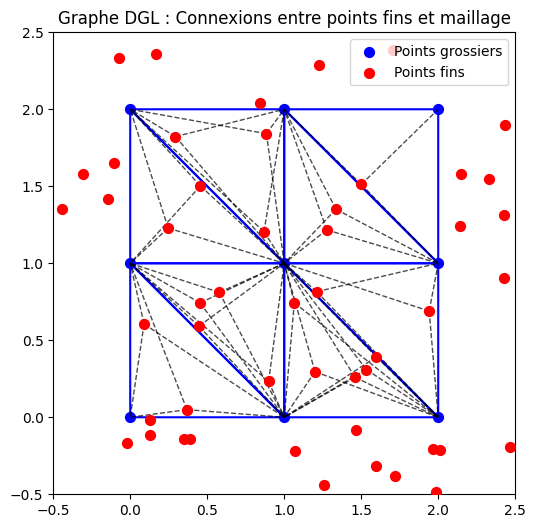

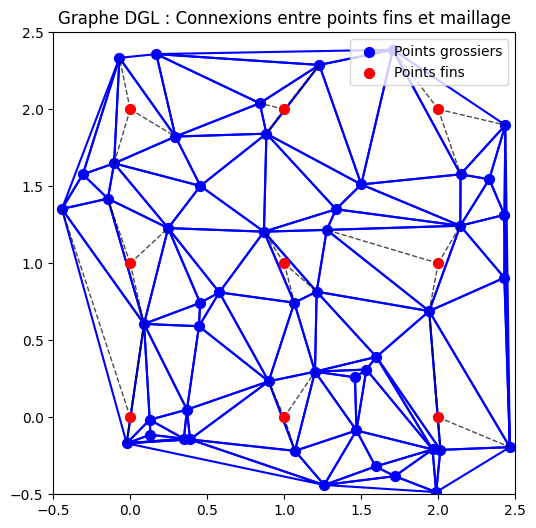

In [9]:
from scipy.spatial import Delaunay


# --- Define the coarse grid and triangles (same as your example) ---
X_coarse = np.array([
        [0, 0], [1, 0], [2, 0],
        [0, 1], [1, 1], [2, 1],
        [0, 2], [1, 2], [2, 2]
    ])
Triangles = np.array([
        [0, 1, 3], [1, 4, 3], [1, 2, 4], [2, 5, 4],
        [3, 4, 6], [4, 7, 6], [4, 5, 7], [5, 8, 7]
    ])

# --- Generate a set of fine points (e.g. 15 points) ---
num_points =  50
X_fin = np.random.uniform(-0.5, 2.5, size=(num_points, 2))
    
tri = Delaunay(X_fin)
Triangles_fin = tri.simplices

graph_down = create_downscale_graph(X_fin, X_coarse, Triangles)
graph_up =  create_downscale_graph(X_coarse,X_fin,Triangles_fin)

plot_graph(X_fin, X_coarse, Triangles, graph_down)
plot_graph(X_coarse,X_fin, Triangles_fin, graph_up)

In [37]:
print(graph_down)

Graph(num_nodes=429066, num_edges=1226235,
      ndata_schemes={}
      edata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32)})


In [10]:
def triangles_to_dgl_graph(simplices):
    """
    Convert a set of triangles from matplotlib.tri simplices to a DGL graph.

    Parameters:
    simplices (ndarray): An (N, 3) array where each row represents a triangle 
                         and contains three vertex indices.

    Returns:
    dgl.DGLGraph: The corresponding graph with edges from the triangulation.
    """
    src, dst = [], []
    
    for tri in simplices:
        # Get all edges in the triangle (undirected)
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        edges += [(b, a) for a, b in edges]  # Ensure bidirectionality
        
        src.extend([e[0] for e in edges])
        dst.extend([e[1] for e in edges])
    
    # Convert to tensor
    src = torch.tensor(src, dtype=torch.int64)
    dst = torch.tensor(dst, dtype=torch.int64)
    
    # Create the DGL graph
    graph = dgl.graph((src, dst))
    
    return graph

graph_fin = triangles_to_dgl_graph(Triangles_fin)
graph_grossier = triangles_to_dgl_graph(Triangles)

In [11]:
node_value_fine = torch.randn((graph_fin.num_nodes(),9))
edge_value_fine = torch.randn(graph_fin.num_edges(),3)

node_value_coarse = torch.randn((graph_grossier.num_nodes(),6))
edge_value_coarse = torch.randn(graph_grossier.num_edges(),3)
    
node_feature_fine = node_encoder_fine(node_value_fine)
node_feature_coarse = node_encoder_coarse(node_value_coarse)

edge_feature_fine = edge_encoder_fine(edge_value_fine)
edge_feature_coarse = edge_encoder_fine(edge_value_coarse)

print(node_feature_fine.shape)
print(node_feature_coarse.shape)
print(edge_feature_fine.shape)
print(edge_feature_coarse.shape)

torch.Size([50, 30])
torch.Size([9, 30])
torch.Size([534, 30])
torch.Size([48, 30])


In [12]:
graph_down_edge_feature = edge_encoder_fine(graph_down.edata['x'])
graph_up_edge_feature = edge_encoder_fine(graph_up.edata['x'])

print(graph_down_edge_feature.shape)
print(graph_up_edge_feature.shape)

torch.Size([63, 30])
torch.Size([27, 30])


#### Faut il conserver les valeurs intermédiaire de chaques étages ???

In [13]:
## Processing fin 
fine_x = processor_fin_1(node_feature_fine,edge_feature_fine,graph_fin)
print(fine_x.shape)
## downscaling
down_scale_feature = torch.cat((fine_x,node_feature_coarse))
print(down_scale_feature.shape)
x = processor_down(down_scale_feature,graph_down_edge_feature,graph_down)
x = x[-node_feature_coarse.shape[0]:,:]
print(x.shape)
## Processing grossier 
x = processor_coarse(x,edge_feature_coarse,graph_grossier)
print(x.shape)
## Upscaling 
up_scale_feature = torch.cat((x,fine_x))
x = processor_up(up_scale_feature,graph_up_edge_feature,graph_up)
x = x[-node_feature_fine.shape[0]:,:]
print(x.shape)
## Processing fin  
final_x = processor_fin_2(x,edge_feature_fine,graph_fin)
print(x.shape)
## decode

torch.Size([50, 30])
torch.Size([59, 30])
torch.Size([9, 30])
torch.Size([9, 30])
torch.Size([50, 30])
torch.Size([50, 30])


In [14]:
from MsMGN import MultiScaleMeshGraphNet

# --- Données de test ---

# Graphe grossier (coarse)
X_coarse = np.array([
    [0, 0], [1, 0], [2, 0],
    [0, 1], [1, 1], [2, 1],
    [0, 2], [1, 2], [2, 2]
])
Triangles = np.array([
    [0, 1, 3], [1, 4, 3], [1, 2, 4], [2, 5, 4],
    [3, 4, 6], [4, 7, 6], [4, 5, 7], [5, 8, 7]
])

# Graphe fin (fine)
num_points = 70
X_fin = np.random.uniform(-0.5, 2.5, size=(num_points, 2))
tri = Delaunay(X_fin)
Triangles_fin = tri.simplices

# Création des 4 graphes séparés
graph_down = create_downscale_graph(X_fin, X_coarse, Triangles)
graph_up = create_downscale_graph(X_coarse, X_fin, Triangles_fin)
graph_fin = triangles_to_dgl_graph(Triangles_fin)
graph_grossier = triangles_to_dgl_graph(Triangles)

# --- Paramètres du modèle ---

input_dim_edges = 3
hidden_dim_processor = 30
hidden_dim_edge_encoder = 30
hidden_dim_node_encoder = 30
activation_fn = get_activation('selu')
num_layers_edge_encoder = 2
num_layers_node_encoder = 2
input_dim_nodes = 9
input_dim_nodes_coarse = 6
processor_size = 3
num_layers_node_processor = 2
num_layers_edge_processor = 2
aggregation = 'sum'
do_concat_trick = True 
num_processor_checkpoint_segments = 0

# --- Création des tenseurs de features ---

# Pour le graphe fin
node_features_fine = torch.randn((graph_fin.num_nodes(), input_dim_nodes))
edge_features_fine = torch.randn((graph_fin.num_edges(), input_dim_edges))
# Pour le graphe grossier
node_features_coarse = torch.randn((graph_grossier.num_nodes(), input_dim_nodes_coarse))
edge_features_coarse = torch.randn((graph_grossier.num_edges(), input_dim_edges))

# --- Instanciation du modèle multi-échelle ---

# Assurez-vous que la classe MultiScaleMeshGraphNet est importée depuis votre module

model = MultiScaleMeshGraphNet(
    input_dim_nodes_fine=input_dim_nodes,
    input_dim_nodes_coarse=input_dim_nodes_coarse,
    input_dim_edges=input_dim_edges,
    output_dim=3,
    processor_size_fine=processor_size,
    processor_size_coarse=processor_size,
    mlp_activation_fn='selu',
    num_layers_node_processor=num_layers_node_processor,
    num_layers_edge_processor=num_layers_edge_processor,
    hidden_dim_processor=hidden_dim_processor,
    hidden_dim_node_encoder=hidden_dim_node_encoder,
    num_layers_node_encoder=num_layers_node_encoder,
    hidden_dim_edge_encoder=hidden_dim_edge_encoder,
    num_layers_edge_encoder=num_layers_edge_encoder,
    hidden_dim_node_decoder=hidden_dim_node_encoder,
    num_layers_node_decoder=num_layers_node_encoder,
    aggregation=aggregation,
    do_concat_trick=do_concat_trick,
    num_processor_checkpoint_segments=num_processor_checkpoint_segments,
)

# --- Passage forward du modèle ---

output = model(
    node_features_fine=node_features_fine,
    node_features_coarse=node_features_coarse,
    edge_features_fine=edge_features_fine,
    edge_features_coarse=edge_features_coarse,
    graph_fine=graph_fin,
    graph_coarse=graph_grossier,
    graph_down=graph_up,
    graph_up=graph_down,
)

print("Output shape:", output.shape)

Output shape: torch.Size([70, 3])


In [15]:
import torch

def hook_print(module, input, output):
    # If output is a tensor, print its shape
    if isinstance(output, torch.Tensor):
        print(f"{module.__class__.__name__} output shape: {output.shape}")
    # If output is a tuple or list, print the shape of each tensor inside
    elif isinstance(output, (tuple, list)):
        shapes = [o.shape for o in output if isinstance(o, torch.Tensor)]
        print(f"{module.__class__.__name__} output shapes: {shapes}")

# Register hooks on the modules we want to track:
hook_handles = []
hook_handles.append(model.node_encoder_fine.register_forward_hook(hook_print))
hook_handles.append(model.edge_encoder_fine.register_forward_hook(hook_print))
hook_handles.append(model.node_encoder_coarse.register_forward_hook(hook_print))
hook_handles.append(model.processor_fin_1.register_forward_hook(hook_print))
hook_handles.append(model.processor_down.register_forward_hook(hook_print))
hook_handles.append(model.processor_coarse.register_forward_hook(hook_print))
hook_handles.append(model.processor_up.register_forward_hook(hook_print))
hook_handles.append(model.processor_fin_2.register_forward_hook(hook_print))
hook_handles.append(model.node_decoder.register_forward_hook(hook_print))

# Run the forward pass (this will trigger the hooks and print the shapes)
output = model(
    node_features_fine=node_features_fine,
    node_features_coarse=node_features_coarse,
    edge_features_fine=edge_features_fine,
    edge_features_coarse=edge_features_coarse,
    graph_fine=graph_fin,
    graph_coarse=graph_grossier,
    graph_down=graph_down,
    graph_up=graph_up,
)

print("Final output shape:", output.shape)

# Optionally, remove the hooks after debugging:
for handle in hook_handles:
    handle.remove()


MeshGraphMLP output shape: torch.Size([70, 30])
MeshGraphMLP output shape: torch.Size([756, 30])
MeshGraphMLP output shape: torch.Size([9, 30])
MeshGraphMLP output shape: torch.Size([48, 30])
MeshGraphMLP output shape: torch.Size([102, 30])
MeshGraphMLP output shape: torch.Size([27, 30])
MeshGraphNetProcessor output shape: torch.Size([70, 30])
MeshGraphNetProcessor output shape: torch.Size([79, 30])
MeshGraphNetProcessor output shape: torch.Size([9, 30])
MeshGraphNetProcessor output shape: torch.Size([79, 30])
MeshGraphNetProcessor output shape: torch.Size([70, 30])
MeshGraphMLP output shape: torch.Size([70, 3])
Final output shape: torch.Size([70, 3])


In [ ]:
print(graph_fin)
print(graph_grossier)
print(graph_up)
print(graph_down)

In [17]:
graph_grossiers, _ = dgl.load_graphs('/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex8/Multimesh_8_32.bin')
graph_fins,_  = dgl.load_graphs('/work/m24046/m24046mrcr/results_data_30min/Multimesh_2_32_True.bin')

In [18]:
graph_grossier = graph_grossiers[0]
graph_fin = graph_fins[0]

In [19]:
print(graph_grossier)
print(graph_fin)

Graph(num_nodes=16222, num_edges=130597,
      ndata_schemes={'static': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32)})
Graph(num_nodes=412844, num_edges=3367766,
      ndata_schemes={'static': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32)})


In [20]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info
from MultiScaleUtils import create_downscale_graph,create_downscale_graph



mesh_grossier_path = '/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex8/Mesh8_corrige.slf'
res_mesh_grossier = TelemacFile(mesh_grossier_path)
X_coarse,Triangles_coarse = add_mesh_info(res_mesh_grossier)


mesh_fin_path = '/work/m24046/m24046mrcr/results_data_30min/maillage_3.slf'
res_mesh_fin = TelemacFile(mesh_fin_path)
X_fin,Triangles_fin = add_mesh_info(res_mesh_fin)


graph_down = create_downscale_graph(X_fin, X_coarse, Triangles_coarse)
graph_up = create_downscale_graph(X_coarse, X_fin, Triangles_fin)

In [21]:
print(graph_down)
print(graph_up)

Graph(num_nodes=429066, num_edges=1226235,
      ndata_schemes={}
      edata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32)})
Graph(num_nodes=429066, num_edges=48444,
      ndata_schemes={}
      edata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32)})


In [22]:
graph_down.edata['x'].numpy()

array([[9.4199531e-02, 2.8091930e-02, 9.8299079e-02],
       [3.7465579e+02, 1.4597191e+02, 4.0208801e+02],
       [3.5559329e+02, 1.7652809e+02, 3.9699969e+02],
       ...,
       [1.0269736e+01, 2.0182283e+01, 2.2644911e+01],
       [9.5230263e+01, 2.2931772e+02, 2.4830508e+02],
       [1.8854277e+02, 1.1281772e+02, 2.1971848e+02]], dtype=float32)

In [23]:
print(np.min(graph_down.edata['x'].numpy()),np.max(graph_down.edata['x'].numpy()))
print(np.min(graph_up.edata['x'].numpy()),np.max(graph_up.edata['x'].numpy()))
print(np.min(graph_fin.edata['x'].numpy()),np.max(graph_fin.edata['x'].numpy()))
print(np.min(graph_grossier.edata['x'].numpy()),np.max(graph_grossier.edata['x'].numpy()))

9.8490855e-06 621.1119
9.8490855e-06 73.4197
-2292.1116 2293.7317
-2521.0625 2521.218


In [24]:
from python.create_dgl_dataset import TelemacDataset  # Import the new dataset
from hydra.utils import to_absolute_path

# Instantiate the dataset with sequence_length=1
dataset = TelemacDataset(
        name="telemac_train",
        data_dir=to_absolute_path('/work/m24046/m24046mrcr/results_data_30min/Multimesh_2_32_True.bin'),
        dynamic_data_files=[to_absolute_path(path) for path in ['/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_1000_Group_3_peak_1000_0_0-80.pkl','/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_1200_Group_3_peak_1200_0_0-80.pkl','/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_1400_Group_3_peak_1400_0_0-80.pkl','/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_1800_Group_3_peak_1800_0_0-80.pkl','/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_2000_Group_3_peak_2000_0_0-80.pkl','/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_2400_Group_3_peak_2400_0_0-80.pkl','/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_2600_Group_3_peak_2600_0_0-80.pkl','/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_2800_Group_3_peak_2800_0_0-80.pkl','/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_3000_Group_3_peak_3000_0_0-80.pkl','/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_3400_Group_3_peak_3400_0_0-80.pkl','/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_3600_Group_3_peak_3600_0_0-80.pkl',]],  # Handle list of files
        split="train",
        ckpt_path="/work/m24046/m24046mrcr/new_tests_Group3/config1_short_multiscale",
        normalize=True,
        sequence_length=1,  # Set sequence length to 1
        )

Normalizing data...


In [25]:
print(dataset.edge_stats)

{'xrel': tensor([0.], dtype=torch.float64), 'yrel': tensor([0.], dtype=torch.float64), 'norm': tensor([24.7882], dtype=torch.float64), 'xrel_std': tensor([33.5479], dtype=torch.float64), 'yrel_std': tensor([33.7876], dtype=torch.float64), 'norm_std': tensor([40.6523], dtype=torch.float64)}


In [26]:
def normalize_graph_edges(graph, stats):
    """
    Normalise les données des arêtes (edata['x']) d'un graphe DGL in-place en utilisant un dictionnaire de statistiques.

    Args:
        graph (dgl.DGLGraph): Le graphe contenant les données des arêtes.
        stats (dict): Un dictionnaire contenant les moyennes et écarts-types des features des arêtes,
                      avec les clés suivantes :
                      - 'xrel', 'yrel', 'norm' (moyennes)
                      - 'xrel_std', 'yrel_std', 'norm_std' (écarts-types)

    Returns:
        None (modifie le graphe in-place)
    """
    if 'x' not in graph.edata:
        raise ValueError("Le graphe ne contient pas edata['x'].")

    # Extraire les valeurs des moyennes et écarts-types
    mean_values = torch.tensor([
        stats['xrel'].item(),
        stats['yrel'].item(),
        stats['norm'].item()
    ], dtype=torch.float32)

    std_values = torch.tensor([
        stats['xrel_std'].item(),
        stats['yrel_std'].item(),
        stats['norm_std'].item()
    ], dtype=torch.float32)

    # Éviter la division par zéro
    epsilon = 1e-8
    std_values = std_values + epsilon

    # Normalisation in-place
    graph.edata['x'] = (graph.edata['x'] - mean_values) / std_values

In [27]:
edge_stats = dataset.edge_stats

normalize_graph_edges(graph_down, edge_stats)
normalize_graph_edges(graph_up, edge_stats)

In [28]:
dataset[0][0].edata['x']

tensor([[-0.1642, -0.0389, -0.4705],
        [ 0.2068,  0.2926, -0.3127],
        [-0.1041, -0.0943, -0.4935],
        ...,
        [-0.0651,  0.1506, -0.4736],
        [-4.4705, -3.1828,  3.9299],
        [-1.2520,  1.1303,  0.7867]])

In [29]:
print(np.min(graph_down.edata['x'].numpy()),np.max(graph_down.edata['x'].numpy()))
print(np.min(graph_up.edata['x'].numpy()),np.max(graph_up.edata['x'].numpy()))
print(np.min(graph_grossier.edata['x'].numpy()),np.max(graph_grossier.edata['x'].numpy()))

print(np.min(dataset[0][0].edata['x'].numpy()),np.max(dataset[0][0].edata['x'].numpy()))

-0.60972595 18.064936
-0.60972595 1.9408541
-2521.0625 2521.218
-68.32355 68.32355


In [30]:
def normalize_graph_edges_static_nodes(graph, edge_stats, nodes_stats):
    """
    Normalise les données des arêtes (edata['x']) et les données statique des noeuds (ndata['static']) d'un graphe DGL in-place en utilisant deux dictionnaire de statistiques.

    Args:
        graph (dgl.DGLGraph): Le graphe contenant les données des arêtes.
        edge_stats (dict): Un dictionnaire contenant les moyennes et écarts-types des features des arêtes,
                      avec les clés suivantes :
                      - 'xrel', 'yrel', 'norm' (moyennes)
                      - 'xrel_std', 'yrel_std', 'norm_std' (écarts-types)
                      
        node_stats (dict): Un dictionnaire contenant les moyennes et écarts-types des features des arêtes,
                      avec les clés suivantes :
                      - 'strickler', 'z' (moyennes)
                      - 'strickler_std', 'z_std' (écarts-types)

    Returns:
        None (modifie le graphe in-place)
    """
    if 'x' not in graph.edata:
        raise ValueError("Le graphe ne contient pas edata['x'].")
        
    if 'static' not in graph.ndata:
        raise ValueError("Le graphe ne contient pas ndata['static'].")

    # Extraire les valeurs des moyennes et écarts-types
    mean_values_edge = torch.tensor([
        edge_stats['xrel'].item(),
        edge_stats['yrel'].item(),
        edge_stats['norm'].item()
    ], dtype=torch.float32)
    
    
    mean_values_node = torch.tensor([
        nodes_stats['strickler'].item(),
        nodes_stats['z'].item(),
    ], dtype=torch.float32)

    std_values_edge = torch.tensor([
        edge_stats['xrel_std'].item(),
        edge_stats['yrel_std'].item(),
        edge_stats['norm_std'].item()
    ], dtype=torch.float32)

    std_values_node = torch.tensor([
        nodes_stats['strickler_std'].item(),
        nodes_stats['z_std'].item(),
    ], dtype=torch.float32)
    
    # Éviter la division par zéro
    epsilon = 1e-8
    std_values_edge = std_values_edge + epsilon
    
    std_values_node = std_values_node + epsilon

    
    # Normalisation in-place
    graph.edata['x'] = (graph.edata['x'] - mean_values_edge) / std_values_edge
    graph.ndata['static'][:,-2:] = (graph.ndata['static'][:,-2:] - mean_values_node) / std_values_node

In [31]:
print(dataset[0][0].ndata['x'][:,4:5])

print(graph_grossier.ndata['static'][:,4:5])

print(graph_grossier.ndata['static'].shape)

tensor([[-0.4577],
        [-0.4845],
        [-0.3452],
        ...,
        [ 0.7232],
        [ 0.2608],
        [ 0.4942]])
tensor([[10.0005],
        [20.0000],
        [19.9997],
        ...,
        [24.2216],
        [13.0135],
        [21.4732]])
torch.Size([16222, 6])


In [32]:
normalize_graph_edges_static_nodes(graph_grossier,dataset.edge_stats,dataset.node_stats)

In [33]:
print(dataset[0][0].ndata['x'][:,4:6])
print(graph_grossier.ndata['static'][:,4:6])

tensor([[-0.4577,  2.3639],
        [-0.4845,  2.3833],
        [-0.3452,  2.3829],
        ...,
        [ 0.7232, -1.2632],
        [ 0.2608, -1.2632],
        [ 0.4942, -1.2632]])
tensor([[-0.9115,  2.3550],
        [-0.0567,  2.5967],
        [-0.0567,  2.2596],
        ...,
        [ 0.3042,  1.0179],
        [-0.6539, -0.4005],
        [ 0.0693, -1.1978]])


In [34]:
print(np.mean(graph_grossier.ndata['static'][:,4].numpy()))
print(np.std(graph_grossier.ndata['static'][:,4].numpy()))

print(np.mean(graph_grossier.edata['x'][:,0].numpy()))
print(np.std(graph_grossier.edata['x'][:,0].numpy()))

-0.032248408
0.9466735
-3.5051623e-10
3.5849125


In [35]:
print(dataset[0][0].edata['x'][:,:])
print(graph_grossier.edata['x'][:,:])
print(graph_up.edata['x'][:,:])
print(graph_down.edata['x'][:,:])


tensor([[-0.1642, -0.0389, -0.4705],
        [ 0.2068,  0.2926, -0.3127],
        [-0.1041, -0.0943, -0.4935],
        ...,
        [-0.0651,  0.1506, -0.4736],
        [-4.4705, -3.1828,  3.9299],
        [-1.2520,  1.1303,  0.7867]])
tensor([[-1.4252,  1.8498,  1.3260],
        [-2.7032,  0.6215,  1.6801],
        [ 1.2408, -0.2368,  0.4329],
        ...,
        [ 0.1584, -2.6933,  1.6325],
        [-2.9827, -8.4203,  6.8089],
        [ 0.2217, -0.1332, -0.3959]])
tensor([[ 6.7022e-04,  1.9578e-04, -6.0919e-01],
        [ 2.9546e-01,  1.3907e-01, -3.3993e-01],
        [ 2.6938e-01,  1.2509e-01, -3.6435e-01],
        ...,
        [ 3.8815e-02,  1.2979e-01, -4.9723e-01],
        [ 4.6764e-02,  3.3533e-02, -5.6216e-01],
        [ 4.5232e-02,  4.0717e-02, -5.5938e-01]])
tensor([[ 2.8079e-03,  8.3143e-04, -6.0734e-01],
        [ 1.1168e+01,  4.3203e+00,  9.2812e+00],
        [ 1.0600e+01,  5.2246e+00,  9.1560e+00],
        ...,
        [ 3.0612e-01,  5.9733e-01, -5.2723e-02],
        [ 2

In [36]:
# --- Création des tenseurs de features ---

# Pour le graphe fin
node_features_fine = torch.randn((graph_fin.num_nodes(), input_dim_nodes))
edge_features_fine = torch.randn((graph_fin.num_edges(), input_dim_edges))
# Pour le graphe grossier
node_features_coarse = torch.randn((graph_grossier.num_nodes(), input_dim_nodes_coarse))
edge_features_coarse = torch.randn((graph_grossier.num_edges(), input_dim_edges))

# --- Instanciation du modèle multi-échelle ---

# Assurez-vous que la classe MultiScaleMeshGraphNet est importée depuis votre module

model = MultiScaleMeshGraphNet(
    input_dim_nodes_fine=input_dim_nodes,
    input_dim_nodes_coarse=input_dim_nodes_coarse,
    input_dim_edges=input_dim_edges,
    output_dim=3,
    processor_size_fine=processor_size,
    processor_size_coarse=processor_size,    mlp_activation_fn='selu',
    num_layers_node_processor=num_layers_node_processor,
    num_layers_edge_processor=num_layers_edge_processor,
    hidden_dim_processor=hidden_dim_processor,
    hidden_dim_node_encoder=hidden_dim_node_encoder,
    num_layers_node_encoder=num_layers_node_encoder,
    hidden_dim_edge_encoder=hidden_dim_edge_encoder,
    num_layers_edge_encoder=num_layers_edge_encoder,
    hidden_dim_node_decoder=hidden_dim_node_encoder,
    num_layers_node_decoder=num_layers_node_encoder,
    aggregation=aggregation,
    do_concat_trick=do_concat_trick,
    num_processor_checkpoint_segments=num_processor_checkpoint_segments,
)

# --- Passage forward du modèle ---

output = model(
    node_features_fine=node_features_fine,
    node_features_coarse=node_features_coarse,
    edge_features_fine=edge_features_fine,
    edge_features_coarse=edge_features_coarse,
    graph_fine=graph_fin,
    graph_coarse=graph_grossier,
    graph_down=graph_down,
    graph_up=graph_up,
)

print("Output shape:", output.shape)


KeyboardInterrupt



### Changement de graph

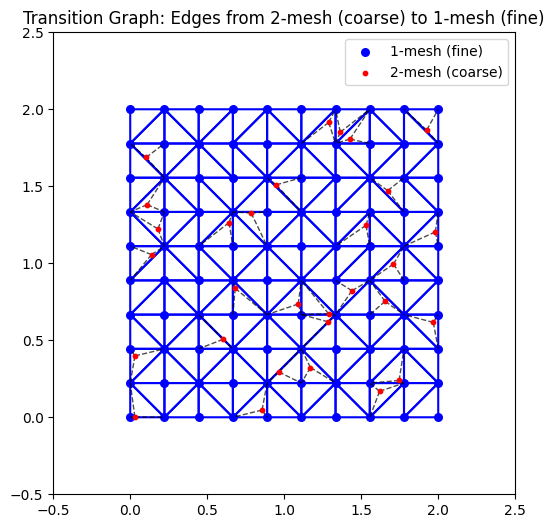

In [3]:
def plot_transition_graph(X_1, X_2, Triangles_1, graph):
    """
    Plots the 1‑mesh (dense, blue) and 2‑mesh (sparse, red) along with the graph edges.
    Each edge connects a 2‑mesh node (after index shift) to a vertex from the 1‑mesh triangle
    in which it is located.
    """
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot the 1-mesh triangles (from dense mesh)
    for tri_indices in Triangles_1:
        pts = X_1[tri_indices]
        polygon = plt.Polygon(pts, edgecolor="blue", fill=None, linewidth=1.5)
        ax.add_patch(polygon)

    # Plot the 1-mesh points (fine, dense)
    ax.scatter(X_1[:, 0], X_1[:, 1], color="blue", label="1-mesh (fine)", s=30, zorder=2)
    
    # Plot the 2-mesh points (coarse, sparse)
    ax.scatter(X_2[:, 0], X_2[:, 1], color="red", label="2-mesh (coarse)", s=10, zorder=3)

    # Extract the edges from the graph.
    # In the graph, 1-mesh nodes are indices [0, N1-1] and 2-mesh nodes are [N1, N1+N2-1].
    src_nodes = graph.edges()[0].numpy()  # these come from the 2-mesh, shifted by len(X_1)
    dst_nodes = graph.edges()[1].numpy()    # these are from the 1-mesh
    
    # For plotting, adjust the source indices to index into X_2
    src_indices = src_nodes - len(X_1)
    
    for src, dst in zip(src_indices, dst_nodes):
        # src indexes X_2 (coarse), dst indexes X_1 (fine)
        x1, y1 = X_2[src]
        x2, y2 = X_1[dst]
        ax.plot([x1, x2], [y1, y2], color="black", linestyle="dashed", linewidth=1, alpha=0.7)

    ax.legend()
    ax.set_title("Transition Graph: Edges from 2-mesh (coarse) to 1-mesh (fine)")
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect("equal")
    plt.show()


# -------------------- Test Data --------------------

import numpy as np
import matplotlib.tri as mtri
import torch
import dgl
import matplotlib.pyplot as plt
import matplotlib

# Generate a dense grid for the 1-mesh (fine)
x1 = np.linspace(0, 2, 10)
y1 = np.linspace(0, 2, 10)
X1 = np.array([[x, y] for x in x1 for y in y1])  # 100 points

# Create a triangulation on the dense 1-mesh
triangulation = mtri.Triangulation(X1[:, 0], X1[:, 1])
Triangles_1 = triangulation.triangles  # triangles referring to the 1-mesh nodes

# Generate a sparse set for the 2-mesh (coarse)
num_points = 30
X2 = np.random.uniform(0, 2, size=(num_points, 2))

# -------------------- Graph Generation --------------------
# Using the new function create_transition_graph (defined earlier)

def create_transition_graph(X_1, X_2, Triangles_1):
    """
    Construct a directed DGL graph where each 2-mesh node connects to the vertices 
    of the 1-mesh triangle it belongs to. In the resulting graph, the 1-mesh nodes 
    have indices [0, N_1-1] and the 2-mesh nodes have indices [N_1, N_1+N_2-1].

    Parameters:
    - X_1: np.array (N_1, 2)  
        Coordinates of 1-mesh nodes.
    - X_2: np.array (N_2, 2)  
        Coordinates of 2-mesh nodes.
    - Triangles_1: np.array (ntri, 3)  
        Triangle vertex indices (counterclockwise order) referring to the 1-mesh nodes.

    Returns:
    - graph: DGL graph with N_2*3 edges.
      Edge features include:
         - relative_position (absolute difference in x and y)
         - distance (Euclidean L2 norm)
    """
    import numpy as np
    import torch
    import dgl
    import matplotlib.tri as tri

    # Create a triangulation on the 1-mesh nodes.
    triangulation = tri.Triangulation(X_1[:, 0], X_1[:, 1], Triangles_1)
    trifinder = triangulation.get_trifinder()
    
    # For each 2-mesh node, determine in which triangle (from the 1-mesh) it lies.
    triangle_indices = trifinder(X_2[:, 0], X_2[:, 1])
    
    # Keep only valid points (those that lie in a triangle, i.e. triangle index != -1)
    valid_mask = triangle_indices >= 0
    valid_indices = np.where(valid_mask)[0]
    valid_triangles = triangle_indices[valid_mask]
    
    # For each valid 2-mesh node, connect it to the 3 vertices of its triangle.
    # Source nodes: indices for 2-mesh nodes shifted by len(X_1)
    src_nodes = np.repeat(valid_indices, 3) + len(X_1)
    
    # Destination nodes: vertices from the 1-mesh triangle (no shift needed)
    dst_nodes = Triangles_1[valid_triangles].flatten()
    
    # Compute relative positions: absolute differences between each 2-mesh node and its connected 1-mesh vertices.
    rel_positions = np.abs(X_2[valid_indices].repeat(3, axis=0) - X_1[dst_nodes])
    
    # Compute Euclidean distances (L2 norm)
    distances = np.linalg.norm(rel_positions, axis=1, keepdims=True)
    
    # Convert arrays to PyTorch tensors.
    src_nodes = torch.from_numpy(src_nodes).long()
    dst_nodes = torch.from_numpy(dst_nodes).long()
    rel_positions = torch.from_numpy(rel_positions).float()
    distances = torch.from_numpy(distances).float()
    
    # Total number of nodes: 1-mesh nodes + 2-mesh nodes.
    num_nodes = len(X_1) + len(X_2)
    
    # Create the directed graph.
    graph = dgl.graph((src_nodes, dst_nodes), num_nodes=num_nodes)
    
    # Attach edge features: concatenate relative positions and distances.
    graph.edata["x"] = torch.cat((rel_positions, distances), axis=1)
    
    return graph

# Create the transition graph
graph = create_transition_graph(X1, X2, Triangles_1)

# Plot the graph
plot_transition_graph(X1, X2, Triangles_1, graph)



In [4]:
import torch
from MultiScaleUtils import create_transition_graph
from create_dgl_dataset import add_mesh_info
from python_code.data_manip.extraction.telemac_file import TelemacFile

# Charger les maillages
mesh_coarse = TelemacFile("/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex8/Mesh8_corrige.slf")
mesh_fine = TelemacFile("/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex2/Mesh2_corrige.slf")

X_coarse, Triangles_coarse = add_mesh_info(mesh_coarse)
X_fine, Triangles_fine = add_mesh_info(mesh_fine)

# Création des graphes
graph_down = create_transition_graph(X_fine, X_coarse, Triangles_fine)
graph_up = create_transition_graph(X_coarse, X_fine, Triangles_coarse)

# Vérifications rapides :
print("Graph down - Nb edges:", graph_down.num_edges(), "Nb nodes:", graph_down.num_nodes())
print("Graph up - Nb edges:", graph_up.num_edges(), "Nb nodes:", graph_up.num_nodes())

# Vérifier les features des edges
print("Edge features (down):", graph_down.edata["x"].shape)
print("Edge features (up):", graph_up.edata["x"].shape)



Graph down - Nb edges: 48441 Nb nodes: 144272
Graph up - Nb edges: 382629 Nb nodes: 144272
Edge features (down): torch.Size([48441, 3])
Edge features (up): torch.Size([382629, 3])


In [5]:
print(X_coarse.shape[0]*3)
print(X_fine.shape[0]*3)

48666
384150


In [6]:
import json

def load_json(file):
    """
    Loads a JSON file into a dictionary of PyTorch tensors.

    Parameters
    ----------
    file : str
        Path to the JSON file.

    Returns
    -------
    Dict[str, torch.Tensor]
        Dictionary where each value is a PyTorch tensor.
    """
    with open(file, "r") as f:
        var_list = json.load(f)
    var = {k: torch.tensor(v, dtype=torch.float) for k, v in var_list.items()}
    return var

In [8]:
print(graph_up)



Graph(num_nodes=144272, num_edges=382629,
      ndata_schemes={}
      edata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32)})


In [12]:
import unittest
import torch
import dgl
import torch.nn as nn

from MsMGN import MeshGraphNetProcessor

class TestDownUpSampling(unittest.TestCase):
    def setUp(self):
        self.hidden_dim = 30
        self.activation = nn.ReLU()
        # Pour le downsampling : 4 nœuds fins et 2 nœuds grossiers.
        self.fine_count = 4
        self.coarse_count = 2

    def test_downsampling(self):
        total_nodes = self.fine_count + self.coarse_count
        # Construire le graphe down : chaque nœud fin (indices 0 à fine_count-1) est connecté à tous les nœuds grossiers (indices fine_count à total_nodes-1)
        src = []
        dst = []
        for i in range(self.fine_count):
            for j in range(self.coarse_count):
                src.append(i)
                dst.append(self.fine_count + j)
        src = torch.tensor(src)
        dst = torch.tensor(dst)
        graph = dgl.graph((src, dst), num_nodes=total_nodes)

        # Initialiser les features des nœuds : nœuds fins = 1, nœuds grossiers = 0
        node_features = torch.zeros(total_nodes, self.hidden_dim)
        node_features[:self.fine_count] = 1.0

        # Initialiser les features des arêtes à 1
        edge_features = torch.ones(graph.num_edges(), self.hidden_dim)

        # Création du processor_down (processor_size=1 pour simplifier)
        processor = MeshGraphNetProcessor(
            processor_size=1,
            input_dim_node=self.hidden_dim,
            input_dim_edge=self.hidden_dim,
            num_layers_node=2,
            num_layers_edge=2,
            aggregation="sum",
            norm_type="LayerNorm",
            activation_fn=self.activation,
            do_concat_trick=False,
            num_processor_checkpoint_segments=0,
        )

        output = processor(node_features, edge_features, graph)
        # Séparer les sorties : nœuds fins (indices 0 à fine_count-1) et nœuds grossiers (indices fine_count à total_nodes-1)
        fine_output = output[:self.fine_count]
        coarse_output = output[self.fine_count:]

        # Vérifier que les sorties des nœuds fins sont homogènes
        self.assertTrue(
            torch.allclose(fine_output, fine_output[0].expand_as(fine_output), atol=1e-5),
            "Les sorties des nœuds fins ne sont pas homogènes."
        )
        # Vérifier que les sorties des nœuds grossiers sont homogènes
        self.assertTrue(
            torch.allclose(coarse_output, coarse_output[0].expand_as(coarse_output), atol=1e-5),
            "Les sorties des nœuds grossiers ne sont pas homogènes."
        )
        # Vérifier que la moyenne des sorties des nœuds grossiers diffère de celle des nœuds fins
        mean_fine = fine_output.mean()
        mean_coarse = coarse_output.mean()
        self.assertFalse(
            torch.allclose(mean_fine, mean_coarse, atol=1e-5),
            "Les sorties des nœuds fins et grossiers ne diffèrent pas comme attendu pour le downsampling."
        )

    def test_upsampling(self):
        # Pour l'upsampling : on considère 2 nœuds grossiers et 4 nœuds fins.
        total_nodes = self.coarse_count + self.fine_count
        # Construire le graphe up : chaque nœud grossier (indices 0 à coarse_count-1) est connecté à tous les nœuds fins (indices coarse_count à total_nodes-1)
        src = []
        dst = []
        for i in range(self.coarse_count):
            for j in range(self.fine_count):
                src.append(i)
                dst.append(self.coarse_count + j)
        src = torch.tensor(src)
        dst = torch.tensor(dst)
        graph = dgl.graph((src, dst), num_nodes=total_nodes)

        # Initialiser les features des nœuds : nœuds grossiers = 1, nœuds fins = 0
        node_features = torch.zeros(total_nodes, self.hidden_dim)
        node_features[:self.coarse_count] = 1.0

        # Initialiser les features des arêtes à 1
        edge_features = torch.ones(graph.num_edges(), self.hidden_dim)

        # Création du processor_up
        processor = MeshGraphNetProcessor(
            processor_size=1,
            input_dim_node=self.hidden_dim,
            input_dim_edge=self.hidden_dim,
            num_layers_node=2,
            num_layers_edge=2,
            aggregation="sum",
            norm_type="LayerNorm",
            activation_fn=self.activation,
            do_concat_trick=False,
            num_processor_checkpoint_segments=0,
        )

        output = processor(node_features, edge_features, graph)
        # Pour l'upsampling, on suppose que les nœuds grossiers sont aux indices 0 à coarse_count-1
        # et les nœuds fins aux indices coarse_count à total_nodes-1.
        coarse_output = output[:self.coarse_count]
        fine_output = output[self.coarse_count:]

        # Vérifier que les sorties des nœuds grossiers sont homogènes
        self.assertTrue(
            torch.allclose(coarse_output, coarse_output[0].expand_as(coarse_output), atol=1e-5),
            "Les sorties des nœuds grossiers ne sont pas homogènes en upsampling."
        )
        # Vérifier que les sorties des nœuds fins sont homogènes
        self.assertTrue(
            torch.allclose(fine_output, fine_output[0].expand_as(fine_output), atol=1e-5),
            "Les sorties des nœuds fins ne sont pas homogènes en upsampling."
        )
        # Vérifier que la moyenne des sorties des nœuds fins diffère de celle des nœuds grossiers
        mean_coarse = coarse_output.mean()
        mean_fine = fine_output.mean()
        self.assertFalse(
            torch.allclose(mean_coarse, mean_fine, atol=1e-5),
            "Les sorties des nœuds fins et grossiers ne diffèrent pas comme attendu pour l'upsampling."
        )

# Exécuter les tests dans le notebook
suite = unittest.TestLoader().loadTestsFromTestCase(TestDownUpSampling)
unittest.TextTestRunner(verbosity=2).run(suite)




test_downsampling (__main__.TestDownUpSampling) ... ok
test_upsampling (__main__.TestDownUpSampling) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.030s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [15]:
import torch
import dgl
import torch.nn as nn
from MultiScaleUtils import create_transition_graph
from create_dgl_dataset import add_mesh_info
from python_code.data_manip.extraction.telemac_file import TelemacFile
from MsMGN import MeshGraphNetProcessor

# Charger les maillages réels
mesh_coarse = TelemacFile("/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex8/Mesh8_corrige.slf")
mesh_fine = TelemacFile("/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex2/Mesh2_corrige.slf")

X_coarse, Triangles_coarse = add_mesh_info(mesh_coarse)
X_fine, Triangles_fine = add_mesh_info(mesh_fine)

# Création des graphes de transition (downsampling et upsampling)
graph_down = create_transition_graph(X_fine, X_coarse, Triangles_fine)
graph_up   = create_transition_graph(X_coarse, X_fine, Triangles_coarse)

print("Graph down - Nb edges:", graph_down.num_edges(), "Nb nodes:", graph_down.num_nodes())
print("Graph up - Nb edges:", graph_up.num_edges(), "Nb nodes:", graph_up.num_nodes())
print("Edge features (down):", graph_down.edata["x"].shape)
print("Edge features (up):", graph_up.edata["x"].shape)

hidden_dim = 30

# Pour le downsampling :
# - Les nœuds fins (X_fine) ont des indices de 0 à N_fine-1
# - Les nœuds grossiers (X_coarse) ont des indices de N_fine à N_fine+N_coarse-1
N_fine   = X_fine.shape[0]
N_coarse = X_coarse.shape[0]
total_nodes_down = graph_down.num_nodes()

node_features_down = torch.zeros(total_nodes_down, hidden_dim)
node_features_down[:N_fine] = 1.0    # nœuds fins initialisés à 1
node_features_down[N_fine:] = 0.0    # nœuds grossiers initialisés à 0

edge_features_down = torch.ones(graph_down.num_edges(), hidden_dim)  # embeddings des arêtes à 1

# Pour l'upsampling :
# - Les nœuds grossiers (X_coarse) ont des indices de 0 à N_coarse-1
# - Les nœuds fins (X_fine) ont des indices de N_coarse à N_coarse+N_fine-1
total_nodes_up = graph_up.num_nodes()

node_features_up = torch.zeros(total_nodes_up, hidden_dim)
node_features_up[:N_coarse] = 1.0    # nœuds grossiers initialisés à 1
node_features_up[N_coarse:] = 0.0    # nœuds fins initialisés à 0

edge_features_up = torch.ones(graph_up.num_edges(), hidden_dim)  # embeddings des arêtes à 1

# Créer les processors pour downsampling et upsampling
processor_down = MeshGraphNetProcessor(
    processor_size=1,
    input_dim_node=hidden_dim,
    input_dim_edge=hidden_dim,
    num_layers_node=2,
    num_layers_edge=2,
    aggregation="sum",
    norm_type="LayerNorm",
    activation_fn=nn.ReLU(),
    do_concat_trick=False,
    num_processor_checkpoint_segments=0,
)

processor_up = MeshGraphNetProcessor(
    processor_size=1,
    input_dim_node=hidden_dim,
    input_dim_edge=hidden_dim,
    num_layers_node=2,
    num_layers_edge=2,
    aggregation="sum",
    norm_type="LayerNorm",
    activation_fn=nn.ReLU(),
    do_concat_trick=False,
    num_processor_checkpoint_segments=0,
)

# Passer les données dans les processors
output_down = processor_down(node_features_down, edge_features_down, graph_down)
output_up   = processor_up(node_features_up, edge_features_up, graph_up)

# Pour le downsampling, extraire les nœuds grossiers (indices de N_fine à total_nodes_down-1)
down_coarse_output = output_down[N_fine:]
print("\nDownsampling - Sorties des nœuds grossiers (devraient être mises à jour et non nulles) :")
print(down_coarse_output)

down_coarse_output = output_down[:N_fine]
print("\nDownsampling - Sorties des nœuds fin (devraient être mises à jour et nulles) :")
print(down_coarse_output)
# Pour l'upsampling, extraire les nœuds fins (indices de N_coarse à total_nodes_up-1)
up_fine_output = output_up[N_coarse:]
print("\nUpsampling - Sorties des nœuds fins (devraient être mises à jour et non nulles) :")
print(up_fine_output)



Graph down - Nb edges: 48441 Nb nodes: 144272
Graph up - Nb edges: 382629 Nb nodes: 144272
Edge features (down): torch.Size([48441, 3])
Edge features (up): torch.Size([382629, 3])

Downsampling - Sorties des nœuds grossiers (devraient être mises à jour et non nulles) :
tensor([[-0.4244,  0.1330, -1.1176,  ...,  0.9915, -0.9648, -0.3756],
        [-0.4244,  0.1330, -1.1176,  ...,  0.9915, -0.9648, -0.3756],
        [-0.4244,  0.1330, -1.1176,  ...,  0.9915, -0.9648, -0.3756],
        ...,
        [-0.4244,  0.1330, -1.1176,  ...,  0.9915, -0.9648, -0.3756],
        [-0.4244,  0.1330, -1.1176,  ...,  0.9915, -0.9648, -0.3756],
        [-0.4244,  0.1330, -1.1176,  ...,  0.9915, -0.9648, -0.3756]],
       grad_fn=<SliceBackward0>)

Downsampling - Sorties des nœuds fin (devraient être mises à jour et nulles) :
tensor([[ 0.7723,  1.0499, -0.8724,  ...,  2.1985, -0.3015,  0.0926],
        [ 0.7723,  1.0499, -0.8724,  ...,  2.1985, -0.3015,  0.0926],
        [ 0.7723,  1.0499, -0.8724,  ...,  